In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

In [ ]:
# References:
# https://github.com/Yunyung/Automatic-Panoramic-Image-Stitching/blob/master/Automatic%20Panoramic%20Image%20Stitching.ipynb
# https://github.com/KEDIARAHUL135/PanoramaStitchingP2

# Modified so that all parameters can be used in OpenGL

class Stitcher:
    def __init__(self):
        self.hl = None
        self.wl = None
        self.hr = None
        self.wr = None
        self.left_is_fixed = None

        self.H = {}
        self.cylin_f = None
        self.border_ratio = None
        self.tl_y = None
        self.tl_x = None
        self.br_y = None
        self.br_x = None

        self.imgs = None
    
    def Stitch_All_Images(self, imgs, f=400):
        n = len(imgs)
        base = 0
        
        # Have to resize in order to converge in matching features step
        (hm, wm) = imgs[base].shape[:2]
        limit_w = 600
        if(wm>limit_w):  # This is just an approximate size
            for i in range(n):
                imgs[i] = cv2.resize(imgs[i],[limit_w, int(hm * limit_w/wm)]) # remain height-width ratio

        self.imgs = imgs
        (hm, wm) = imgs[base].shape[:2]
        self.cylin_f = f / wm # rescale for OpenGL

        # Perform cylindrical projection
        for i in range(n):
            imgs[i] = self.Cylindrical_Projection(imgs[i], f)

        # Remove black border
        (imgs[0], border) = self.RemoveBlackBorder_Cylin(imgs[0], border=0)
        self.border_ratio = float(border / wm) # for OpenGL
        for i in range(1,n):
            imgs[i] = self.RemoveBlackBorder_Cylin(imgs[i], border)

        # For OpenGL
        print('float buf_data [{}];'.format((n-1)*3*3))

        # Start stitching
        # Find all homography matrices of each image wrt base image
        
        # from base to right
        H_base_i = np.eye(3)
        self.H[base] = H_base_i
        for i in range(base+1, n):
            H_l_r = self.stitch([imgs[i-1],imgs[i]], left_is_fixed = True)
            H_base_i = np.dot(H_base_i, H_l_r)
            self.PrintHomo(H_base_i, i-1) # will print H_base_i inverse transpose
            self.H[i] = H_base_i

        stitch_img = self.Warp_All_Images(imgs, self.H, undrift = 0.0)
        
        # For OpenGL
        print('glUniform1f(glGetUniformLocation(shaderProgram.ID, "f"), {});'.format(self.cylin_f))
        print('glUniform1f(glGetUniformLocation(shaderProgram.ID, "border_ratio"), {});'.format(self.border_ratio))

        return stitch_img

    def Cylindrical_Projection(self, img, f):
        (h, w) = img.shape[:2]
        (center_y, center_x) = (h/2.0, w/2.0)
        result = np.zeros((h, w, 3), dtype=np.uint8)
        for i in range(h):
            for j in range(w):
                xt = (f * np.tan((float)(j - center_x) / f)) + center_x
                yt = ((float)(i - center_y) / np.cos((float)(j - center_x) / f)) + center_y
                
                # Nearest interpolation
                xt = int(round(xt))
                yt = int(round(yt))
                if(xt>=0 and xt<w and yt>=0 and yt<h):
                    result[i, j] = img[yt, xt]

        return result

    def Spherical_Projection(self, img, f):
        (h, w) = img.shape[:2]
        (center_y, center_x) = (h/2.0, w/2.0)
        result = np.zeros((h, w, 3), dtype=np.uint8)
        for i in range(h):
            for j in range(w):
                theta = (j-center_x)/f
                phi = (i-center_y)/f
                xt = f * np.tan(theta) + center_x
                yt = f * np.tan(phi) / np.cos(theta) + center_y
                # Nearest interpolation
                xt = int(round(xt))
                yt = int(round(yt))
                if(xt>=0 and xt<w and yt>=0 and yt<h):
                    result[i, j] = img[yt, xt]
        return result

    def RemoveBlackBorder_Cylin(self, img, border = 0):
        h, w = img.shape[:2]

        # border is known
        if(border != 0):
            return img[:, border:w-border]

        # left to right
        for col in range(w):
            all_black = True
            for i in range(h):
                if (np.count_nonzero(img[i, col]) > 0):
                    all_black = False
                    break
            if (all_black == True):
                border += 1
            else:
                break

        return (img[:, border:w-border], border)

    def Warp_All_Images(self, imgs, H, undrift):
        # OpenGL stitching method 
        assert (len(imgs) == len(H))
        n = len(imgs)
        base = 0
        (hm, wm) = imgs[base].shape[:2]
        (h, w) = (hm, wm*n)
        stitch_img = np.zeros((h, w, 3), dtype=np.uint8) # create the (stitch) big image according the imgs height and width 
        
        H_ = {}
        for i in range(n):
            H_[i] = np.linalg.inv(H[i])

        for i in np.linspace(0.0, 1.0, h, endpoint=False):
            for j in np.linspace(-base, n-base, w, endpoint=False):
                drift_i = i - undrift * pow((j+base)/n, 2);
                texCoord_b = np.array([j, drift_i, 1])
                for k in range(n):
                    texCoord = (np.dot(H_[k], texCoord_b))
                    texCoord /= texCoord[2] # normalize          
                    (x, y) = texCoord[:2]
                    if (x >= 0.0 and x < 1.0 and y >= 0.0 and y < 1.0):
                        stitch_img[int(i*h), int((j+base) * w/n)] = imgs[k][int(y*hm), int(x*wm)]
                        break
                
        return stitch_img
    
    # Print the H inverse transpose for OpenGL application
    def PrintHomo(self, H, bias):
        H_ = np.linalg.inv(H)
        H_T = H_.T # the reason for transpose is OpenGL Shader uses column major
        addr = bias * 9
        for i in range(3):
            for j in range(3):
                print('buf_data[{}] = {};'.format(addr, H_T[i,j]), end =" ")
                addr += 1
            print('')

    def Undrift(self, img, br_y, br_x):
        (h,w) = img.shape[:2]
        bl_x = 0
        bl_y = None

        # Find the most bottom left pixel
        i = h-1
        while(i > 0):
            if(np.count_nonzero(img[i, bl_x]) > 0):
                bl_y = i
                break
            if(i==1):
                i = h-1
                bl_x += 1
            elif(bl_x == w):
                assert False, "Undrift Error: Cannot find any pixel!"
            i -= 1

        # Find the most bottom right pixel
        # i = h-1
        # while(i > 0):
        #     if(np.count_nonzero(img[i, br_x]) > 0):
        #         if(np.count_nonzero(img[i+1, br_x-2])==0):
        #             br_y = i
        #             break
        #         br_x -= 1
        #         i = h-1
        #     if(i==1):
        #         i = h-1
        #         br_x -= 1
        #     i -= 1

        stitch_img = np.array(img)
        gap_x = br_x - bl_x
        gap_y = bl_y - br_y
        a = gap_y / pow(gap_x,2)
        for x in range(bl_x,w):
            amount = min(max(int(a * pow((x-bl_x),2)), 0), h-1)

            try:
                stitch_img[:amount ,x] = 0
                stitch_img[amount:h ,x] = img[0:h-amount ,x]
            except:
                print('Cannot shift {} pixel'.format(amount))
        
        gap_x /= w
        gap_y /= h
        a = gap_y / pow(gap_x,2)
        print('glUniform1f(glGetUniformLocation(shaderProgram.ID, "undrift"), {});'.format(a))
        return stitch_img

    def stitch(self, imgs, left_is_fixed = True):
        '''
            Stitch two images
        '''
        img_left, img_right = imgs

        (self.hl, self.wl) = img_left.shape[:2]
        (self.hr, self.wr) = img_right.shape[:2]
        self.left_is_fixed = left_is_fixed
        
        kps_l, features_l = self.detectAndDescribe(img_left)
        kps_r, features_r = self.detectAndDescribe(img_right)

        if(left_is_fixed):
            matches_pos = self.matchKeyPoint(kps_l, kps_r, features_l, features_r, ratio = 0.75)
        else:
            matches_pos = self.matchKeyPoint(kps_r, kps_l, features_r, features_l, ratio = 0.75)
        # print("The number of matching points:", len(matches_pos))
        
        return self.fitHomoMat(matches_pos)
        
    def detectAndDescribe(self, img):
        '''
        The Detector and Descriptor
        '''
        # SIFT detector and descriptor
        sift = cv2.xfeatures2d.SIFT_create()
        kps, features = sift.detectAndCompute(img,None)
        
        return kps, features
    
    def matchKeyPoint(self, kps_l, kps_r, features_l, features_r, ratio):
        '''
            Match the Keypoints beteewn two image
        '''
        Match_idxAndDist = [] # min corresponding index, min distance, seccond min corresponding index, second min distance
        for i in range(len(features_l)):
            min_IdxDis = [-1, np.inf]  # record the min corresponding index, min distance
            secMin_IdxDis = [-1 ,np.inf]  # record the second corresponding min index, min distance
            for j in range(len(features_r)):
                dist = np.linalg.norm(features_l[i] - features_r[j])
                if (min_IdxDis[1] > dist):
                    secMin_IdxDis = np.copy(min_IdxDis)
                    min_IdxDis = [j , dist]
                elif (secMin_IdxDis[1] > dist and secMin_IdxDis[1] != min_IdxDis[1]):
                    secMin_IdxDis = [j, dist]
            
            Match_idxAndDist.append([min_IdxDis[0], min_IdxDis[1], secMin_IdxDis[0], secMin_IdxDis[1]])

        # ratio test as per Lowe's paper
        goodMatches = []
        for i in range(len(Match_idxAndDist)):
            if (Match_idxAndDist[i][1] <= Match_idxAndDist[i][3] * ratio):
                goodMatches.append((i, Match_idxAndDist[i][0]))
            
        goodMatches_pos = []
        for (idx, correspondingIdx) in goodMatches:
            psA = (int(kps_l[idx].pt[0]), int(kps_l[idx].pt[1]))
            psB = (int(kps_r[correspondingIdx].pt[0]), int(kps_r[correspondingIdx].pt[1]))
            goodMatches_pos.append([psA, psB])
            
        return goodMatches_pos
    
    def fitHomoMat(self, matches_pos):
        '''
            Fit the best homography model with RANSAC algorithm
        '''
        dstPoints = [] # i.e. left image(destination image)
        srcPoints = [] # i.e. right image(source image) 
        for dstPoint, srcPoint in matches_pos:
            dstPoints.append(list(dstPoint)) # (x,y)
            srcPoints.append(list(srcPoint))
        dstPoints = np.array(dstPoints)
        srcPoints = np.array(srcPoints)

        if(self.left_is_fixed):
            dstPoints = dstPoints / np.array([self.wl, self.hl])
            srcPoints = srcPoints / np.array([self.wr, self.hr])
        else:
            dstPoints = dstPoints / np.array([self.wr, self.hr])
            srcPoints = srcPoints / np.array([self.wl, self.hl])
        
        # RANSAC algorithm, selecting the best fit homography
        NumSample = len(matches_pos)
        threshold = 0.005
        NumIter = 2000
        NumRamdomSubSample = 4
        MaxInlier = 0
        Best_H = None
        
        for run in range(NumIter):
            SubSampleIdx = random.sample(range(NumSample), NumRamdomSubSample) # get the Index of ramdom sampling
            H = self.solve_homography(srcPoints[SubSampleIdx], dstPoints[SubSampleIdx])
            
            # find the best Homography have the the maximum number of inlier
            NumInlier = 0 
            for i in range(NumSample):
                if i not in SubSampleIdx:
                    concateCoor = np.hstack((srcPoints[i], [1])) # add z-axis as 1
                    dstCoor = H @ concateCoor.T # calculate the coordination after transform to destination img 
                    if dstCoor[2] <= 1e-8: # avoid divide zero number, or too small number cause overflow
                        continue
                    dstCoor = dstCoor / dstCoor[2]
                    if (np.linalg.norm(dstCoor[:2] - dstPoints[i]) < threshold):
                        NumInlier = NumInlier + 1
            if (MaxInlier < NumInlier):
                MaxInlier = NumInlier
                Best_H = H
                
        # print("The Number of Maximum Inlier:", MaxInlier)
        
        return Best_H
    
    def solve_homography(self, P, m):
        '''
        Solve homography matrix 

        Args:
            P:  Coordinates of the points in the original plane,
            m:  Coordinates of the points in the target plane

        Returns:
            H: Homography matrix 
        '''
        try:
            A = []  
            for r in range(len(P)): 
                A.append([-P[r,0], -P[r,1], -1, 0, 0, 0, P[r,0]*m[r,0], P[r,1]*m[r,0], m[r,0]])
                A.append([0, 0, 0, -P[r,0], -P[r,1], -1, P[r,0]*m[r,1], P[r,1]*m[r,1], m[r,1]])

            u, s, vt = np.linalg.svd(A) # Solve system of linear equations Ah = 0 using SVD
            # pick H from last line of vt  
            H = np.reshape(vt[8], (3,3))
            # normalization, let H[2,2] equals to 1
            H = (1/H.item(8)) * H
        except:
            print("Error occur!")

        return H

    def Cut_Final(self, stitch_img, top_left, bottom_right):
        (h,w) = stitch_img.shape[:2]
        (tl_y, tl_x) = top_left
        (br_y, br_x) = bottom_right
        self.tl_y = float(tl_y / h)
        self.tl_x = float(tl_x / w)
        self.br_y = float(br_y / h)
        self.br_x = float(br_x / w)
        print('float tl_y = {};'.format(self.tl_y))
        print('float tl_x = {};'.format(self.tl_x))
        print('float br_y = {};'.format(self.br_y))
        print('float br_x = {};'.format(self.br_x))
        return stitch_img[tl_y:br_y, tl_x:br_x]

In [ ]:
# Stitch images using OpenGL method
img0 = cv2.imread('field0.jpg')
img1 = cv2.imread('field1.jpg')
img2 = cv2.imread('field2.jpg')
img3 = cv2.imread('field3.jpg')
img4 = cv2.imread('field4.jpg')
img5 = cv2.imread('field5.jpg')

imgs = [img0,img1,img2,img3,img4,img5]

stitcher = Stitcher()

# We have to guess the f value, maybe can start with f = 400
# Depend on stitching result:
# If image is distorted, decrease f and try again
# If image is too concentrated into the center, increase f and try again
stitch_img = stitcher.Stitch_All_Images(imgs, f=425)

float buf_data [45];
buf_data[0] = 1.0440431349854553; buf_data[1] = 0.09396861788171709; buf_data[2] = 0.0033231587979345384; 
buf_data[3] = -0.09811125837669636; buf_data[4] = 1.0831161257515687; buf_data[5] = 0.07816047357260474; 
buf_data[6] = -0.46363365653343047; buf_data[7] = -0.12253833767828178; buf_data[8] = 0.992716912756655; 
buf_data[9] = 1.0280288817349985; buf_data[10] = 0.1129719503455058; buf_data[11] = -0.02104281414318166; 
buf_data[12] = -0.19104281568805942; buf_data[13] = 1.0866352069199552; buf_data[14] = 0.10077512263704645; 
buf_data[15] = -0.8594272751503724; buf_data[16] = -0.160651361474773; buf_data[17] = 1.0120056424304118; 
buf_data[18] = 0.9764166451652467; buf_data[19] = 0.13279874495920152; buf_data[20] = -0.042563985482310725; 
buf_data[21] = -0.3072769369017973; buf_data[22] = 1.0017888002416937; buf_data[23] = 0.039731456216849016; 
buf_data[24] = -1.0937262367977834; buf_data[25] = -0.1576075011339191; buf_data[26] = 1.036687797057253; 
buf_data[27

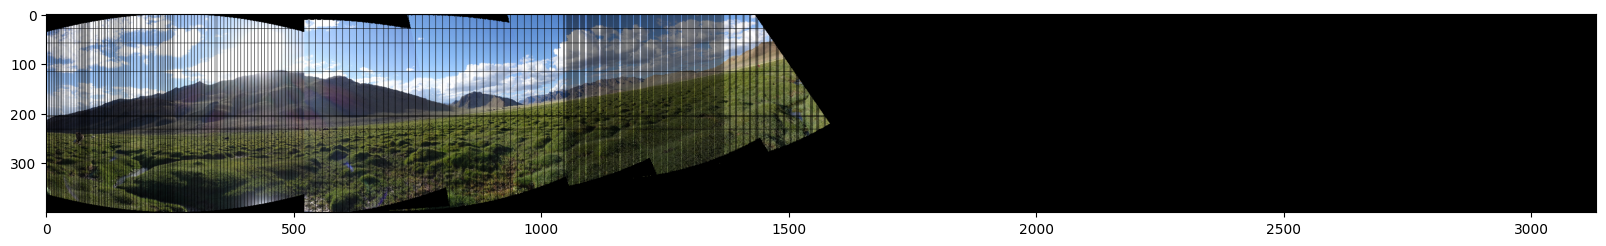

In [ ]:
# Plot the stitching result, note that the weird grids are caused by OpenGL stitching method, we can just ignore it
_ = cv2.cvtColor(stitch_img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20,24))
plt.imshow(_)

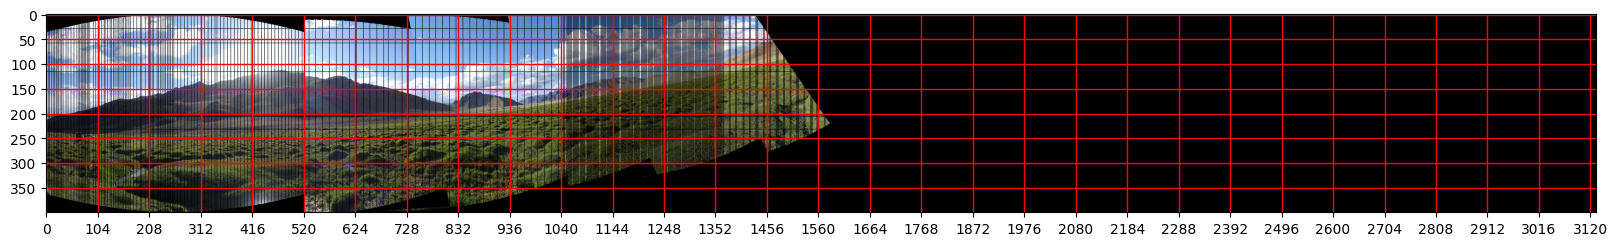

In [ ]:
# To find the most bottom right pixel for undrift
_ = cv2.cvtColor(stitch_img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20,24))
ax = fig.add_subplot(1, 1, 1)

(h,w) = _.shape[:2]
major_ticks_x = np.arange(0, w, w//30)
major_ticks_y = np.arange(0, h, h//8)

ax.set_xticks(major_ticks_x)
ax.set_yticks(major_ticks_y)
plt.grid(color='r', linestyle='-', linewidth=1)
plt.imshow(_)

In [ ]:
# For example, bottom right pixel is at (210,1560)
straigh_img = stitcher.Undrift(stitch_img, 210, 1560)
# Copy the output code and paste to OpenGL too

glUniform1f(glGetUniformLocation(shaderProgram.ID, "undrift"), 1.5417918639053256);


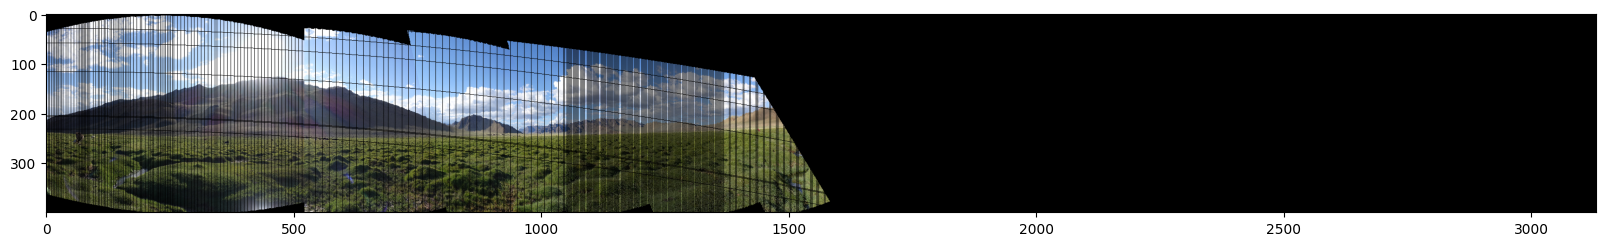

In [ ]:
# Plot the straighten result
_ = cv2.cvtColor(straigh_img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20,24))
plt.imshow(_)

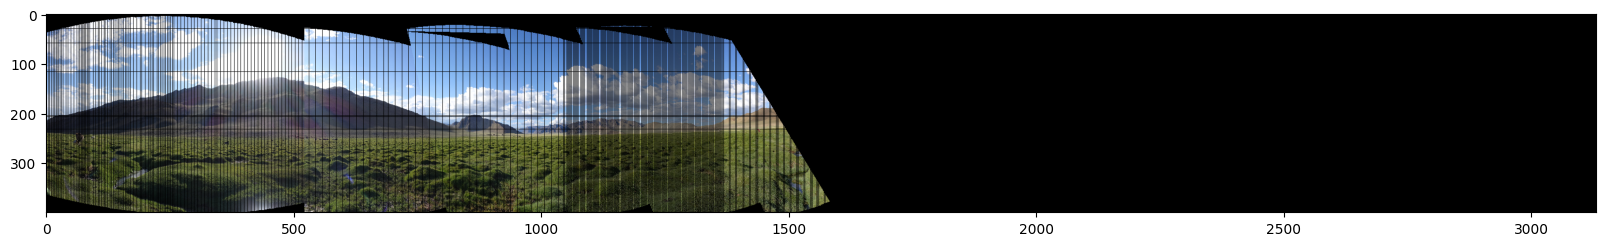

In [ ]:
# Verify by re-warping
stitch_img = stitcher.Warp_All_Images(stitcher.imgs, stitcher.H, 1.5417918639053256)
# Plot the stitching result, note that the weird grids are caused by OpenGL stitching method, we can just ignore it
_ = cv2.cvtColor(stitch_img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20,24))
plt.imshow(_)

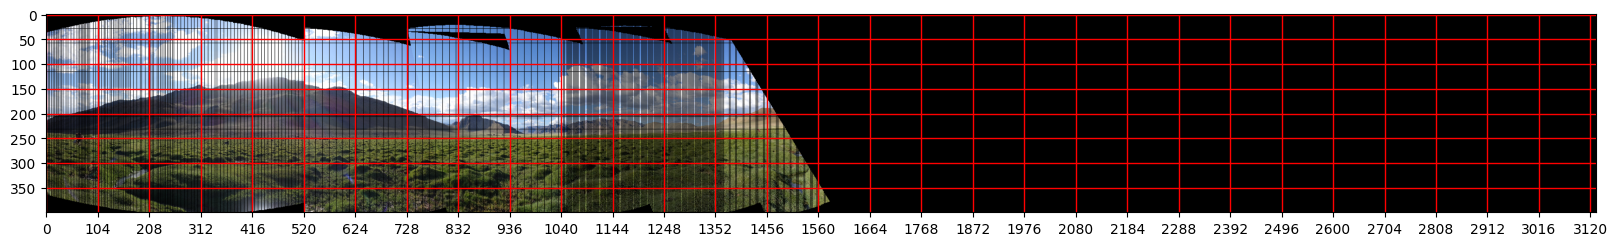

In [ ]:
# To find a proper coordinate for cropping
_ = cv2.cvtColor(stitch_img, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20,24))
ax = fig.add_subplot(1, 1, 1)

(h,w) = _.shape[:2]
major_ticks_x = np.arange(0, w, w//30)
major_ticks_y = np.arange(0, h, h//8)

ax.set_xticks(major_ticks_x)
ax.set_yticks(major_ticks_y)
plt.grid(color='r', linestyle='-', linewidth=1)
plt.imshow(_)

float tl_y = 0.17;
float tl_x = 0.0;
float br_y = 0.9;
float br_x = 0.44699872286079184;


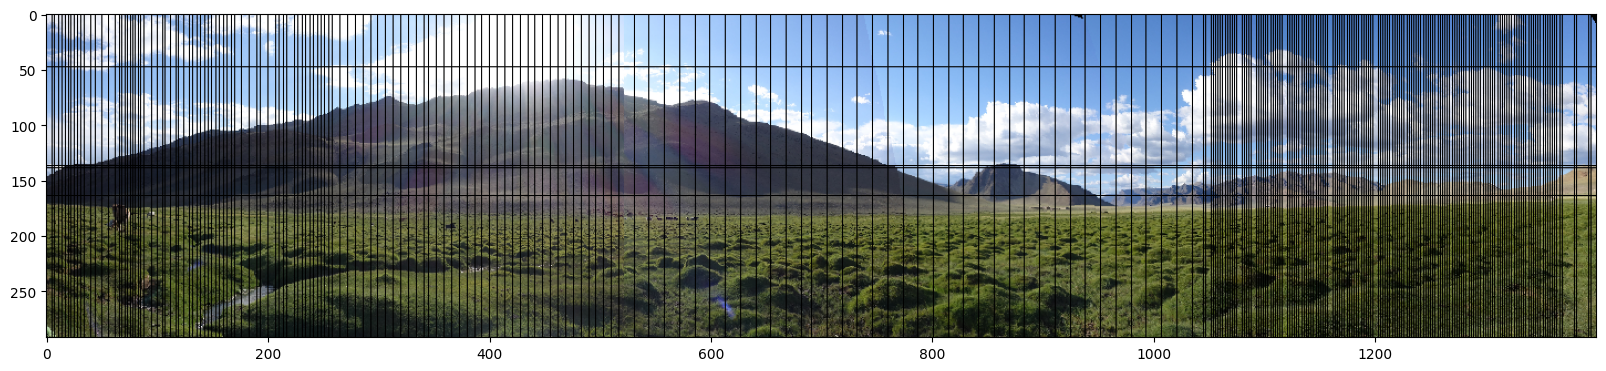

In [ ]:
# Try and error until we get a desired cropping area
top_left = (68,0) # (y,x)
bottom_right = (360,1400) # (y,x)
final = stitcher.Cut_Final(stitch_img, top_left, bottom_right)
_ = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(20,24))
plt.imshow(_)
# Copy the output code and paste to OpenGL too

In [ ]:
# Average Homography (if needed in the future)
def Average(H0, H1):
  HA = (H0 + H1) / 2
  print(HA)
  return HA

In [ ]:
# Find Weight Map by Distance Transform (for blending)
def DT(img):
  white = np.ones((img.shape[0],img.shape[1],1), dtype=np.uint8) * 255
  white[0,:] = 0
  white[-1,:] = 0
  white[:,0] = 0
  white[:,-1] = 0
  dist = cv2.distanceTransform(white, cv2.DIST_L2, 3) # Euclidean distance
  dist = (dist / np.max(dist)) * 255 #Normalize
  # dist = white
  dist = np.array(dist)
  dist = dist.astype(np.uint8)

  # (h,w) = dist.shape[:2]
  # dist[h//2-450:h//2+450,w//2-700:w//2+700] = 255
  # dist[:,:] = 255
  # dist[0,:] = 0
  # dist[-1,:] = 0
  # dist[:,0] = 0
  # dist[:,-1] = 0
  # dist[dist==0] = 1 # Avoid divide by 0 (in OpenGL)
  cv2.imwrite("WM.jpg", dist)
  return dist

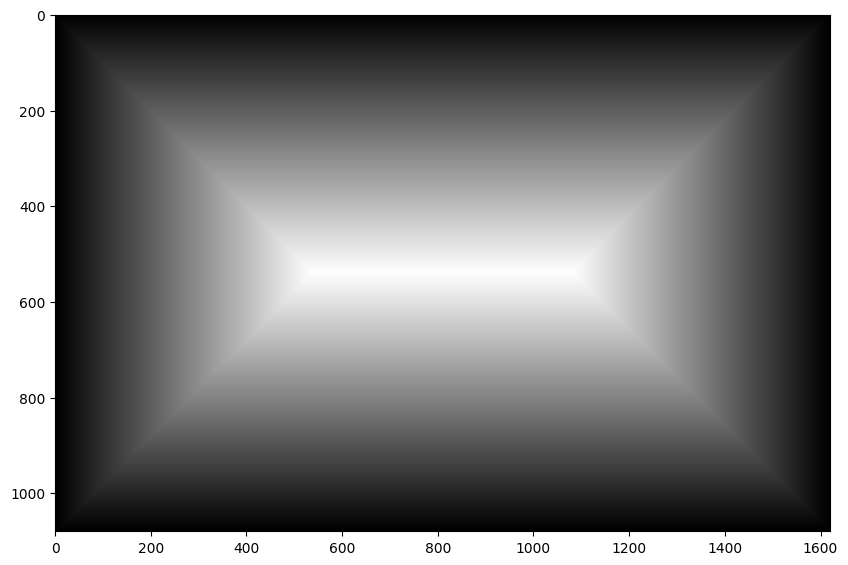

In [ ]:
# We only need to transform one image
img = cv2.imread('field0.jpg')
dist = DT(img)
_ = cv2.cvtColor(dist, cv2.COLOR_BGR2RGB)
fig = plt.figure(figsize=(10,12))
plt.imshow(_)